# IF3270 Machine Learning | Praktikum

This notebook serves as a template for the assignment. Please create a copy of this notebook to complete your work. You can add more code blocks, markdown blocks, or new sections if needed.


Group Number: 50

Group Members:
- Bagas Sambega Rosyada (13522071)
- Raden Francisco Trianto B. (13522091)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

### Download Data with gdown

In [ ]:
!pip install gdown

In [ ]:
import gdown
url = "https://drive.google.com/uc?export=download&id=1obePZndeoytAGeaB-T01nwjzF2xlGojM"
output = 'dataset.zip'
gdown.download(url, output)

Downloading...
From: https://drive.google.com/uc?export=download&id=1obePZndeoytAGeaB-T01nwjzF2xlGojM
To: /content/dataset.zip
100%|██████████| 47.2k/47.2k [00:00<00:00, 71.0MB/s]


'dataset.zip'

In [ ]:
!unzip dataset.zip

Archive:  dataset.zip
  inflating: test.csv                
  inflating: train.csv               


## Import Libraries

In [ ]:
import pandas as pd
import numpy as np

## Import Dataset

In [ ]:
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')

# 1. Exploratory Data Analysis

Exploratory Data Analysis (EDA) is a crucial step in the data analysis process that involves examining and visualizing data sets to uncover patterns, trends, anomalies, and insights. It is the first step before applying more advanced statistical and machine learning techniques. EDA helps you to gain a deep understanding of the data you are working with, allowing you to make informed decisions and formulate hypotheses for further analysis. Use simple statistical analysis to get a grip on the used data

In [ ]:
print("Train Set Preview:")
print(train_df.head())

print("\Test Set Preview:")
print(test_df.head())

print("\nTrain Columns:", train_df.columns)
print("\nTest Columns:", test_df.columns)

Train Set Preview:
         time       h1
0  2022-01-01  16853.0
1  2022-01-02  14155.0
2  2022-01-03  14439.0
3  2022-01-04  11273.0
4  2022-01-05  10750.0
\Test Set Preview:
         time  h1
0  2045-04-10   1
1  2045-04-11   1
2  2045-04-12   1
3  2045-04-13   1
4  2045-04-14   1

Train Columns: Index(['time', 'h1'], dtype='object')

Test Columns: Index(['time', 'h1'], dtype='object')


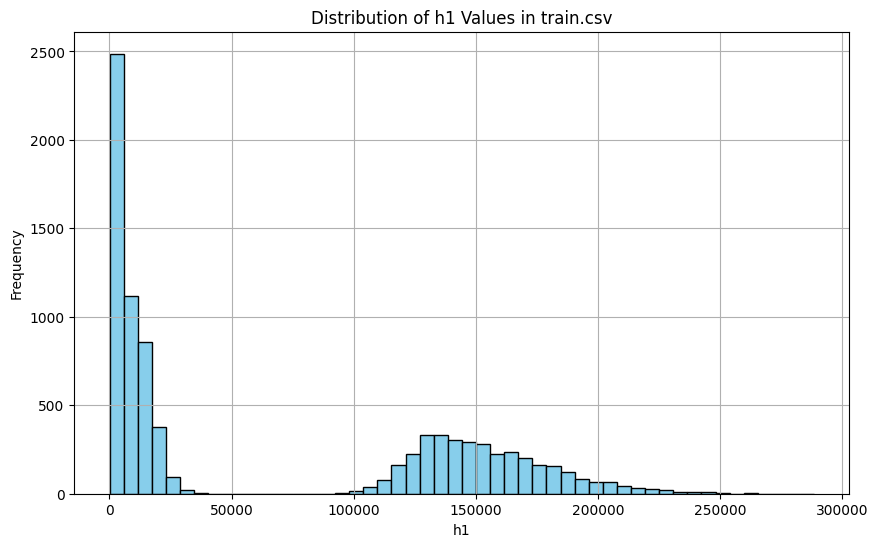

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(train_df['h1'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of h1 Values in train.csv')
plt.xlabel('h1')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 2. Split Training Set and Validation Set

Splitting the training and validation set works as an early diagnostic towards the performance of the model we train. This is done before the preprocessing steps to **avoid data leakage inbetween the sets**. If you want to use k-fold cross-validation, split the data later and do the cleaning and preprocessing separately for each split.

In [ ]:
from sklearn.model_selection import train_test_split

X = train_df['h1'].values  # or whatever the appropriate features are
y = train_df['h1'].shift(-1).dropna().values  # predicting next h1



# 3. Data Cleaning and Preprocessing

This step is the first thing to be done once a Data Scientist have grasped a general knowledge of the data. Raw data is **seldom ready for training**, therefore steps need to be taken to clean and format the data for the Machine Learning model to interpret.

By performing data cleaning and preprocessing, you ensure that your dataset is ready for model training, leading to more accurate and reliable machine learning results. These steps are essential for transforming raw data into a format that machine learning algorithms can effectively learn from and make predictions.

For each step that you will do, **please explain the reason why did you do that process. Write it in a markdown cell under the code cell you wrote.**

In [ ]:
# Check for missing values
print("Missing in Train:\n", train_df.isnull().sum())
print("Missing in Val:\n", test_df.isnull().sum())

# Drop or fill
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)


Missing in Train:
 time    0
h1      0
dtype: int64
Missing in Val:
 time    0
h1      0
dtype: int64


In [ ]:
if 'time' in train_df.columns:
    train_df['time'] = pd.to_datetime(train_df['time'])
    train_df.set_index('time', inplace=True)

if 'time' in test_df.columns:
    test_df['time'] = pd.to_datetime(test_df['time'])
    test_df.set_index('time', inplace=True)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_df[['h1']])
test_scaled = scaler.transform(test_df[['h1']])

In [ ]:
import numpy as np

def create_sliding_window(data, time_steps=30, add_padding=False):
    X, y = [], []

    # For training data without padding
    if not add_padding:
        for i in range(len(data) - time_steps):
            X.append(data[i:(i + time_steps), 0])
            y.append(data[i + time_steps, 0])
    # For test data with padding to preserve original length that went missing after creating sliding window
    else:
        # Add padding
        padding = np.full((time_steps, 1), data[0, 0])
        padded_data = np.vstack((padding, data))

        # create sequences that include the padding
        for i in range(len(data)):
            X.append(padded_data[i:(i + time_steps), 0])
            y.append(data[i, 0])  # The actual value

    return np.array(X), np.array(y)

def reshape_for_lstm(X):
    return np.reshape(X, (X.shape[0], X.shape[1], 1))

time_steps = 30  # can tune later
X, y = create_sliding_window(train_scaled, time_steps)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train_lstm = reshape_for_lstm(X_train)
X_val_lstm = reshape_for_lstm(X_val)
X_test, y_test = create_sliding_window(test_scaled, time_steps, add_padding=True)


In [ ]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print(f"Validation data shape: {X_val.shape}")
print(f"Validation y shape: {y_val.shape}")
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("Test df shape:", test_df.shape)

X_train shape: (6776, 30)
y_train shape: (6776,)
Validation data shape: (1694, 30)
Validation y shape: (1694,)
X_test shape: (1500, 30)
y_test shape: (1500,)
Test df shape: (1500, 1)


In [ ]:
def reshape_for_nn(X):
    return np.reshape(X, (X.shape[0], X.shape[1], 1))

In [ ]:
X_train_reshaped = reshape_for_nn(X_train)
X_val_reshaped = reshape_for_nn(X_val)
X_test_reshaped = reshape_for_nn(X_test)

# Compile Preprocessing Pipeline

All of the preprocessing classes or functions defined earlier will be compiled in this step.

If you use sklearn to create preprocessing classes, you can list your preprocessing classes in the Pipeline object sequentially, and then fit and transform your data.

In [ ]:
# We are not using any pipeline :)

# from sklearn.pipeline import Pipeline

# # Note: You can add or delete preprocessing components from this pipeline

# pipe = Pipeline([("imputer", FeatureImputer()),
#                  ("featurecreator", FeatureCreator()),
#                  ("scaler", FeatureScaler()),
#                  ("encoder", FeatureEncoder())])

# train_set = pipe.fit_transform(train_set)
# val_set = pipe.transform(val_set)

or create your own here

# 4. Modeling and Validation

Modeling is the process of building a machine learning model to solve a particular problem, or in the context of this task, predicting each value in time. Validation is the process of evaluating your trained model using the validation set or cross-validation method and providing some metrics that can help you decide what to do in the next iteration of development.

In [ ]:
time_steps = 30  # Window size
batch_size = 32
epochs = 10

In [ ]:
def inverse_transform_predictions(predictions):
    # Reshape predictions to match scaler input shape
    predictions_reshaped = predictions.reshape(-1, 1)
    # Inverse transform
    return scaler.inverse_transform(predictions_reshaped)

In [ ]:
callbacks = [
    # Stop training when validation loss stops improving
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.0001
    )
]


## 4.1 Recurrent Neural Network

You need to build and compare two models:
- Build your own model with RNN architecture using PyTorch/Tensorflow.
- Build your own model with LSTM architecture using PyTorch/Tensorflow.


### 4.1.1 Build Your Own Model (RNN)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input

def build_rnn_model(time_steps, features=1):
  rnn_model = Sequential([
      # Input(shape=(X_train.shape[1], X_train.shape[2])),
      SimpleRNN(64, activation='tanh', input_shape=(time_steps, features)),
      Dense(1)  # regression output
  ])

  rnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
  rnn_model.summary()
  return rnn_model

In [ ]:
rnn_model = build_rnn_model(time_steps)
rnn_history = rnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 64)             │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,289 (16.75 KB)

 Trainable params: 4,289 (16.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0159 - mae: 0.0657 - val_loss: 6.8713e-04 - val_mae: 0.0099 - learning_rate: 0.0010
Epoch 2/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0017 - mae: 0.0235 - val_loss: 5.6397e-04 - val_mae: 0.0088 - learning_rate: 0.0010
Epoch 3/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0013 - mae: 0.0203 - val_loss: 5.4651e-04 - val_mae: 0.0086 - learning_rate: 0.0010
Epoch 4/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0012 - mae: 0.0198 - val_loss: 5.1493e-04 - val_mae: 0.0083 - learning_rate: 0.0010
Epoch 5/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0013 - mae: 0.0205 - val_loss: 4.9403e-04 - val_mae: 0.0081 - learning_rate: 0.0010
Epoch 6/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0012 - mae: 0.0194 - val_loss: 4.7367e-04 - val_mae: 0.0083 - learning_rate: 0.0010
Epoch 7/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0011 - mae: 0.0197 - val_loss: 4.8006e-04 - val_mae: 0.0080 -

In [ ]:
rnn_predictions = rnn_model.predict(X_test)
rnn_predictions = inverse_transform_predictions(rnn_predictions).flatten()

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [ ]:
print(rnn_predictions)

[473.9496 473.9496 473.9496 ... 473.9496 473.9496 473.9496]


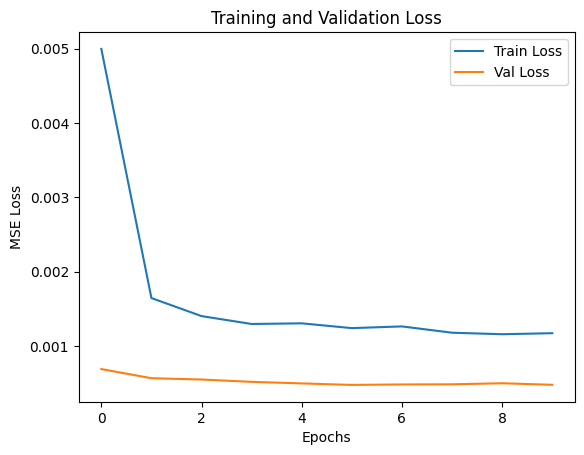

In [ ]:
import matplotlib.pyplot as plt

plt.plot(rnn_history.history['loss'], label='Train Loss')
plt.plot(rnn_history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

### 4.1.2 Build Your Own Model (LSTM)

In [ ]:
def build_lstm_model(time_steps, features=1):
    model = Sequential([
        # First LSTM layer
        LSTM(128, activation='relu', return_sequences=True,
             input_shape=(time_steps, features)),
        Dropout(0.3),  # Prevent overfitting

        # Second LSTM layer
        LSTM(64, activation='relu'),
        Dropout(0.3),

        # Output layer
        Dense(1)
    ])

    # Compile model with Adam optimizer and MSE loss
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss='mse',
        metrics=['mae']
    )

    return model


In [ ]:
lstm_model = build_lstm_model(time_steps)
lstm_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 30, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,033 (453.25 KB)

 Trainable params: 116,033 (453.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
lstm_history = lstm_model.fit(
    X_train_lstm, y_train,
    validation_data=(X_val_lstm, y_val),
    epochs=15,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1,
    shuffle=False
)

Epoch 1/15


Exception ignored in: <function _xla_gc_callback at 0x79d47f4d4fe0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 


212/212 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - loss: 0.0106 - mae: 0.0600 - val_loss: 0.0331 - val_mae: 0.0806 - learning_rate: 5.0000e-04
Epoch 2/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0091 - mae: 0.0582 - val_loss: 0.0244 - val_mae: 0.0678 - learning_rate: 5.0000e-04
Epoch 3/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0077 - mae: 0.0560 - val_loss: 0.0081 - val_mae: 0.0415 - learning_rate: 5.0000e-04
Epoch 4/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0049 - mae: 0.0464 - val_loss: 0.0042 - val_mae: 0.0290 - learning_rate: 5.0000e-04
Epoch 5/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0040 - mae: 0.0408 - val_loss: 0.0028 - val_mae: 0.0198 - learning_rate: 5.0000e-04
Epoch 6/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0038 - mae: 0.0383 - val_loss: 0.0037 - val_mae: 0.0241 - learning_rate: 5.0000e-04
Epoch 7/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0038 - mae: 0.0379 - val_loss: 0.0039 - val_mae: 0.0259 - learning_rate

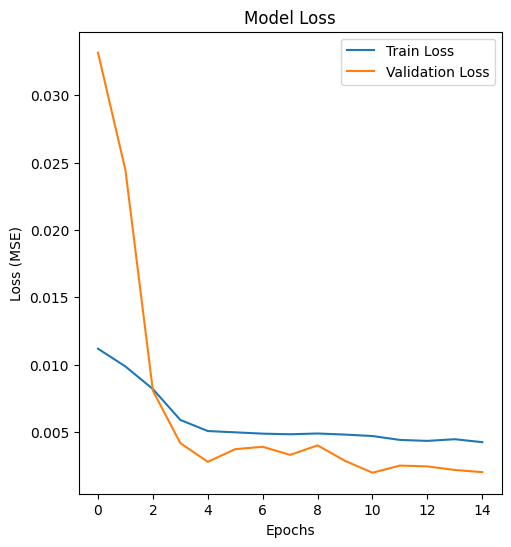

In [ ]:

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(lstm_history.history['loss'], label='Train Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()


In [ ]:
lstm_predictions = lstm_model.predict(X_test)
print(lstm_predictions)

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
[[0.02090271]
 [0.02090271]
 [0.02090271]
 ...
 [0.02090271]
 [0.02090271]
 [0.02090271]]


In [ ]:
lstm_predictions = inverse_transform_predictions(lstm_predictions).flatten()
print(lstm_predictions)

[6106.581 6106.581 6106.581 ... 6106.581 6106.581 6106.581]


## 4.2 Validation

Validation is the process of evaluating a trained model using a validation set or cross-validation method. It provides metrics that help determine the necessary steps for the next iteration of model development.  

For validation, the metric used is **macro f1-score**. A higher f1-score indicates better model calibration.  

### Required Validation Results  
The validation results that must be included in the notebook are:  
1. The validation results from the required baseline models.  
2. The validation results from the final submission model on **Kaggle**.  

In [ ]:
rnn_train_preds = rnn_model.predict(X_train)
rnn_val_preds = rnn_model.predict(X_val)
lstm_train_preds = lstm_model.predict(X_train)
lstm_val_preds = lstm_model.predict(X_val)

# Inverse transform all predictions and actual values
rnn_train_preds = inverse_transform_predictions(rnn_train_preds).flatten()
rnn_val_preds = inverse_transform_predictions(rnn_val_preds).flatten()
lstm_train_preds = inverse_transform_predictions(lstm_train_preds).flatten()
lstm_val_preds = inverse_transform_predictions(lstm_val_preds).flatten()
y_train_actual = inverse_transform_predictions(y_train.reshape(-1, 1)).flatten()
y_val_actual = inverse_transform_predictions(y_val.reshape(-1, 1)).flatten()

212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [ ]:
y_train_actual = inverse_transform_predictions(y_train.reshape(-1, 1)).flatten()
y_val_actual = inverse_transform_predictions(y_val.reshape(-1, 1)).flatten()

In [ ]:
import math
from sklearn.metrics import mean_squared_error, f1_score

def calculate_rmse(actual, predicted):
    return math.sqrt(mean_squared_error(actual, predicted))

In [ ]:
rnn_train_rmse = calculate_rmse(y_train_actual, rnn_train_preds)
rnn_val_rmse = calculate_rmse(y_val_actual, rnn_val_preds)
lstm_train_rmse = calculate_rmse(y_train_actual, lstm_train_preds)
lstm_val_rmse = calculate_rmse(y_val_actual, lstm_val_preds)

In [ ]:
def calculate_f1(actual, predicted, threshold=5000):
    actual_binary = (actual > threshold).astype(int)
    predicted_binary = (predicted > threshold).astype(int)
    return f1_score(actual_binary, predicted_binary, average='weighted')

In [ ]:
threshold = np.mean(y_train_actual)
rnn_train_f1 = calculate_f1(y_train_actual, rnn_train_preds, threshold)
rnn_val_f1 = calculate_f1(y_val_actual, rnn_val_preds, threshold)
lstm_train_f1 = calculate_f1(y_train_actual, lstm_train_preds, threshold)
lstm_val_f1 = calculate_f1(y_val_actual, lstm_val_preds, threshold)

In [ ]:
# Print evaluation metrics
print("\n--- Evaluation Metrics ---\n")
print("RNN - Train RMSE: {:.2f}, Validation RMSE: {:.2f}".format(rnn_train_rmse, rnn_val_rmse))
print("RNN - Train F1: {:.4f}, Validation F1: {:.4f}".format(rnn_train_f1, rnn_val_f1))
print("LSTM - Train RMSE: {:.2f}, Validation RMSE: {:.2f}".format(lstm_train_rmse, lstm_val_rmse))
print("LSTM - Train F1: {:.4f}, Validation F1: {:.4f}".format(lstm_train_f1, lstm_val_f1))



--- Evaluation Metrics ---

RNN - Train RMSE: 9783.21, Validation RMSE: 6280.12
RNN - Train F1: 0.9997, Validation F1: 0.9994
LSTM - Train RMSE: 20564.08, Validation RMSE: 12815.56
LSTM - Train F1: 0.9985, Validation F1: 0.9958


## Submission
To predict the test set target feature and submit the results to the kaggle competition platform, do the following:
1. Create a new pipeline instance identical to the first in Data Preprocessing
2. With the pipeline, apply `fit_transform` to the original training set before splitting, then only apply `transform` to the test set.
3. Retrain the model on the preprocessed training set
4. Predict the test set

In [ ]:
rnn_results_df = pd.DataFrame()

if isinstance(test_df.index, pd.DatetimeIndex):
    # If test_df already has a datetime index, use that
    rnn_results_df['time'] = test_df.index[:len(rnn_predictions)]
else:
    # If there's no datetime index, check if there's a 'time' column in the original data
    if 'time' in test_df.columns:
        rnn_results_df['time'] = test_df['time'].iloc[:len(rnn_predictions)].values
    else:
        import datetime
        start_date = datetime.datetime.now()
        dates = [start_date + datetime.timedelta(days=i) for i in range(len(rnn_predictions))]
        rnn_results_df['time'] = dates

# Add the h1 predictions
rnn_results_df['h1'] = rnn_predictions

rnn_results_df.to_csv('/content/result_rnn.csv', index=False)

In [ ]:
lstm_results_df = pd.DataFrame()

# Add date column
if isinstance(test_df.index, pd.DatetimeIndex):
    # If test_df already has a datetime index, use that
    # Note: We need to account for the time_steps offset
    # The predictions start at position time_steps in the original data
    lstm_results_df['time'] = test_df.index[0:1500]
else:
    # If there's no datetime index, check if there's a 'time' column in the original data
    if 'time' in test_df.columns:
        lstm_results_df['time'] = test_df['time'].iloc[time_steps:time_steps+len(lstm_predictions)].values
    else:
        import datetime
        start_date = datetime.datetime.now()
        dates = [start_date + datetime.timedelta(days=i) for i in range(len(lstm_predictions))]
        lstm_results_df['time'] = dates

# Add the h1 predictions
lstm_results_df['h1'] = lstm_predictions

lstm_results_df.to_csv('/content/result_lstm_3.csv', index=False)

print(f"Results saved to '/content/result_lstm_3.csv'")
print("Preview of results:")
print(lstm_results_df.head())

Results saved to '/content/result_lstm_3.csv'
Preview of results:
        time           h1
0 2045-04-10  4695.055176
1 2045-04-11  4695.055176
2 2045-04-12  4695.055176
3 2045-04-13  4695.055176
4 2045-04-14  4695.055176


# 5. Error Analysis

Based on all the process you have done until the modeling and evaluation step, write an analysis to support each steps you have taken to solve this problem. Write the analysis using the markdown block. Some questions that may help you in writing the analysis:

1. What is the error distribution between classes? Do most misclassifications come from one class?
2. Are there more false positives or false negatives?
3. Do occlusions or unusual angles contribute to errors?
4. Are the misclassifications random or do they follow a certain pattern?
5. etc..

Since we're using regression value, we cannot calculate the error distribution between classes. From the experiment, the model training loss value for LSTM is lower than RNN. From that, we can conclude LSTM's result is better than RNN. The RMSE value of LSTM is also lower and better than RNN. This is caused by LSTM capability of saving long-term memory and saving gate to select which time-series to forget or delete.

# 6. Insights

For each step you have done, do an analysis and mention the insights obtained.

From the Exploratory Data Analysis, we can conclude time is a time-series column and each time-series is contributing effect to the next time-series.

The dataset is already clean, there is no null value. But the distribution of the dataset is not normal.

From the modelling and validation, we can conclude that the LSTM model provide better result than RNN.